# Détection d'utilisateurs suspects sur Twitter à l'aide du SVM et de la PCA

In [3]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

## Importations & Chargement des données

Nous commençons par importer les bibliothèques nécessaires et charger le dataset contenant les profils utilisateurs labellisés comme "suspect" ou "non suspect".

In [ ]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample


# Chargement du dataset
# df_labelisé = pd.read_csv("cleaned_data_with_validated_label.csv")
df_labelisé = pd.read_csv("../traitement_des_données/cleaned_data_with_anomaly_label.csv") # Utiliser lors de l'exécution locale
df_labelisé = df_labelisé.head(700000)

# Aperçu de la taille du jeu de données
df_labelisé.shape

FileNotFoundError: [Errno 2] No such file or directory: '../traitement_des_données/cleaned_data_with_validated_label.csv'

## Répartition des classes

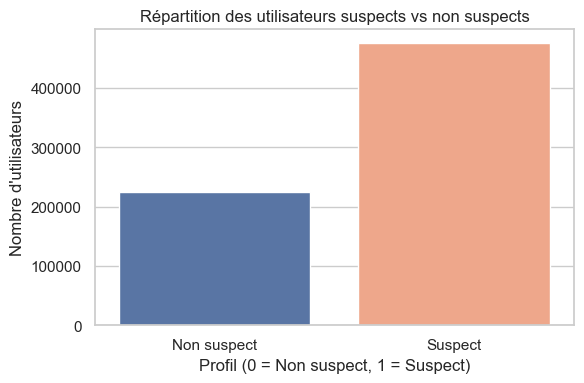

In [5]:
# Style de base
sns.set(style="whitegrid")

# Visualisation de la répartition des profils "suspect" et "non suspect"
plot_df_labelisé = df_labelisé['label'].value_counts().reset_index()
plot_df_labelisé.columns = ['label', 'count']

# Affichage avec nouvelle palette
plt.figure(figsize=(6, 4))
sns.barplot(
    data=plot_df_labelisé,
    x='label',
    y='count',
    hue='label',
    palette={0: '#4C72B0', 1: '#FFA07A'},  # bleu + orange doux
    legend=False
)

plt.title("Répartition des utilisateurs suspects vs non suspects")
plt.xlabel("Profil (0 = Non suspect, 1 = Suspect)")
plt.ylabel("Nombre d'utilisateurs")
plt.xticks([0, 1], ["Non suspect", "Suspect"])
plt.tight_layout()
plt.show()


## Matrice de corrélation avant PCA

In [ ]:
numeric_cols = df_labelisé.select_dtypes(include=['int64', 'float64']).columns.drop('label','user_id')
X_numeric = df_labelisé[numeric_cols].dropna()

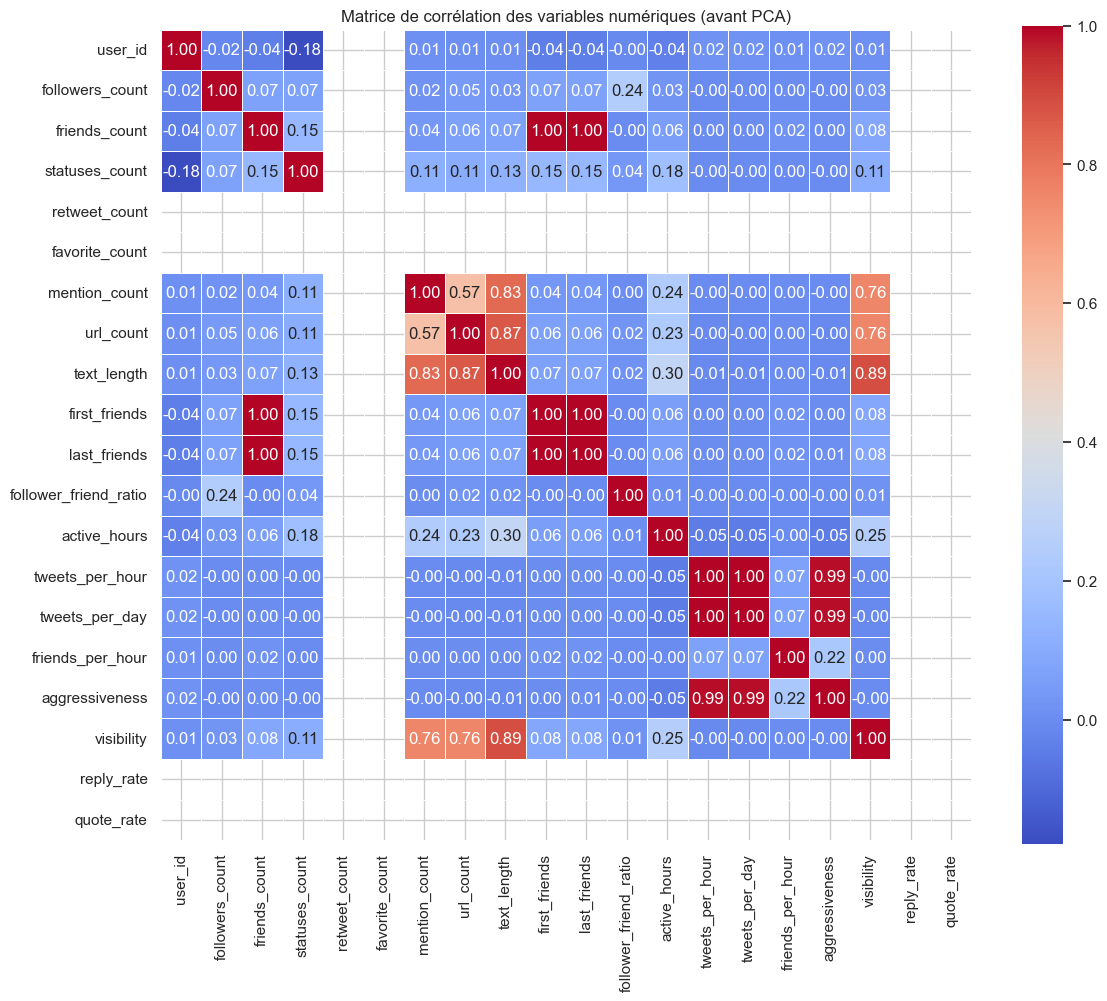

In [ ]:
plt.figure(figsize=(12, 10))
corr_matrix = X_numeric.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Matrice de corrélation des variables numériques (avant PCA)")
plt.tight_layout()
plt.show()


## Analyse en Composantes Principales (PCA)

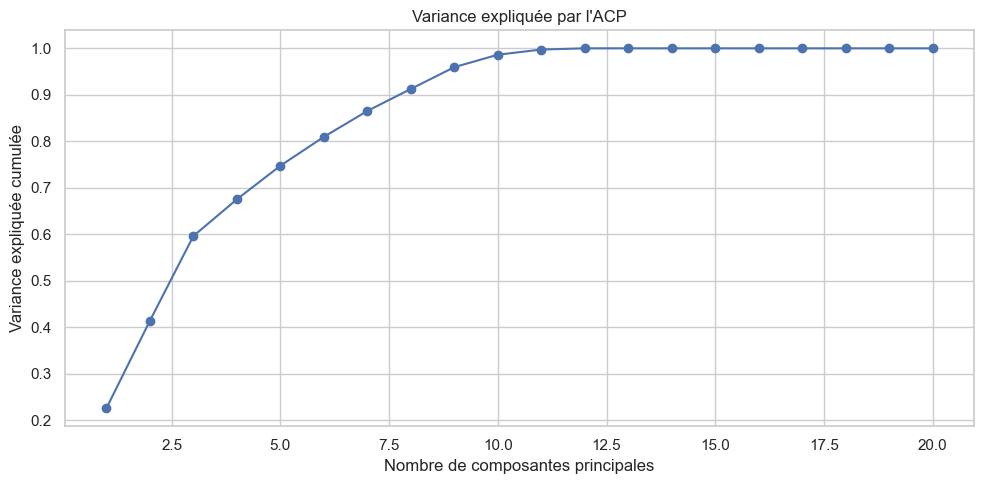

In [ ]:
# 2. Centrage et réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# 3. ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4. Affichage de la variance expliquée cumulée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# 5. Visualisation du coude
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par l'ACP")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Trouver le nombre minimal de composantes pour atteindre au moins 80 % de variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1

# Affichage
print(f"Nombre de composantes principales à conserver pour expliquer au moins 80% de la variance : {n_components_80}")

Nombre de composantes principales à conserver pour expliquer au moins 80% de la variance : 6


## Construction du jeu de données pour l'apprentissage supervisé

In [ ]:
# Construction du dataset (A revoir)import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    adjusted_rand_score, silhouette_score
)

from scipy.stats import mode
from scipy.spatial import distance
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn import metrics, cluster
from sklearn.svm import SVC


# 4. Garder les 9 premières composantes
X_pca_9 = X_pca[:, :6]
df_pca = pd.DataFrame(X_pca_9, columns=[f'PC{i+1}' for i in range(6)])

# 5. Encoder les variables catégorielles utiles
categorical_cols = df_labelisé.select_dtypes(include=['object', 'bool']).columns
cols_to_exclude = ['user_name', 'tweets', 'user_created_at', 'user_description', 'user_location']
categorical_cols = [col for col in categorical_cols if col not in cols_to_exclude]

# Label encoding
label_encoder = LabelEncoder()
df_encoded = df_labelisé[categorical_cols].copy()
for col in df_encoded.columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

# 6. Fusion ACP + variables catégorielles encodées
dataset_final = pd.concat([df_pca.reset_index(drop=True), df_encoded.reset_index(drop=True)], axis=1)

# 7. Réintégration de la variable cible 'profil'
dataset_final['label'] = df_labelisé.loc[dataset_final.index, 'label'].values

In [ ]:
dataset_final.head()

,PC1,PC2,PC3,PC4,PC5,PC6,label
0,-0.414973,-0.073142,0.224136,0.159748,-0.328897,-0.053379,1
1,0.103652,0.096867,0.708277,-0.126308,0.054715,-0.098046,1
2,-0.526072,-0.117406,0.040973,-0.068780,0.022571,-0.078204,1
3,0.544423,-0.207891,-0.187345,0.360103,-0.762936,0.108016,0
4,-0.572342,-0.116488,0.056396,-0.057790,0.011333,-0.076469,1


In [ ]:
dataset_final.shape

(700000, 7)

## Entraînement et évaluation du SVM

In [ ]:
df_svm = dataset_final.sample(n=700000, random_state=42)

X = df_svm.drop(columns=['label'])
y = df_svm['label']

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Résultats du SVM :")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")


Résultats du SVM :
Accuracy  : 0.9643
Precision : 0.9821
Recall    : 0.9650
F1-score  : 0.9735


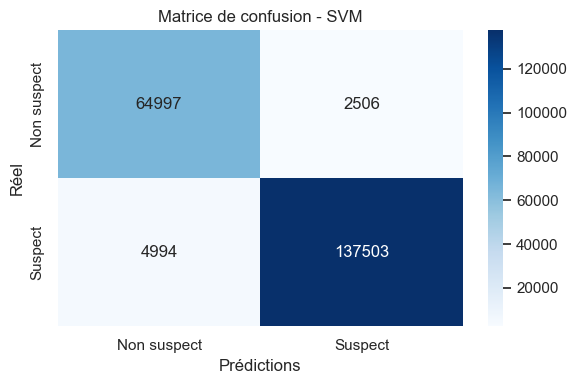

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non suspect", "Suspect"],
            yticklabels=["Non suspect", "Suspect"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion - SVM")
plt.tight_layout()
plt.show()